In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [4]:
## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15371355769722226089
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15302447494434559203
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2688233598026829495
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7304675328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17219281498897027707
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [5]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

4423680/4422102 [==============================] - 0s 0us/step


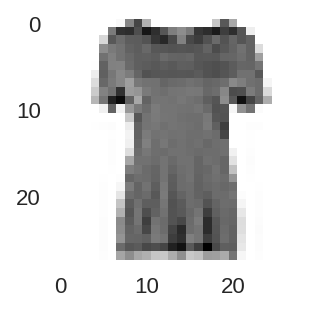

In [6]:
# Show an image

fig = plt.figure(figsize=(2,2), dpi=160, facecolor='w')
ax = fig.add_subplot(111)

ax.imshow(train_images[10])
ax.grid(False)


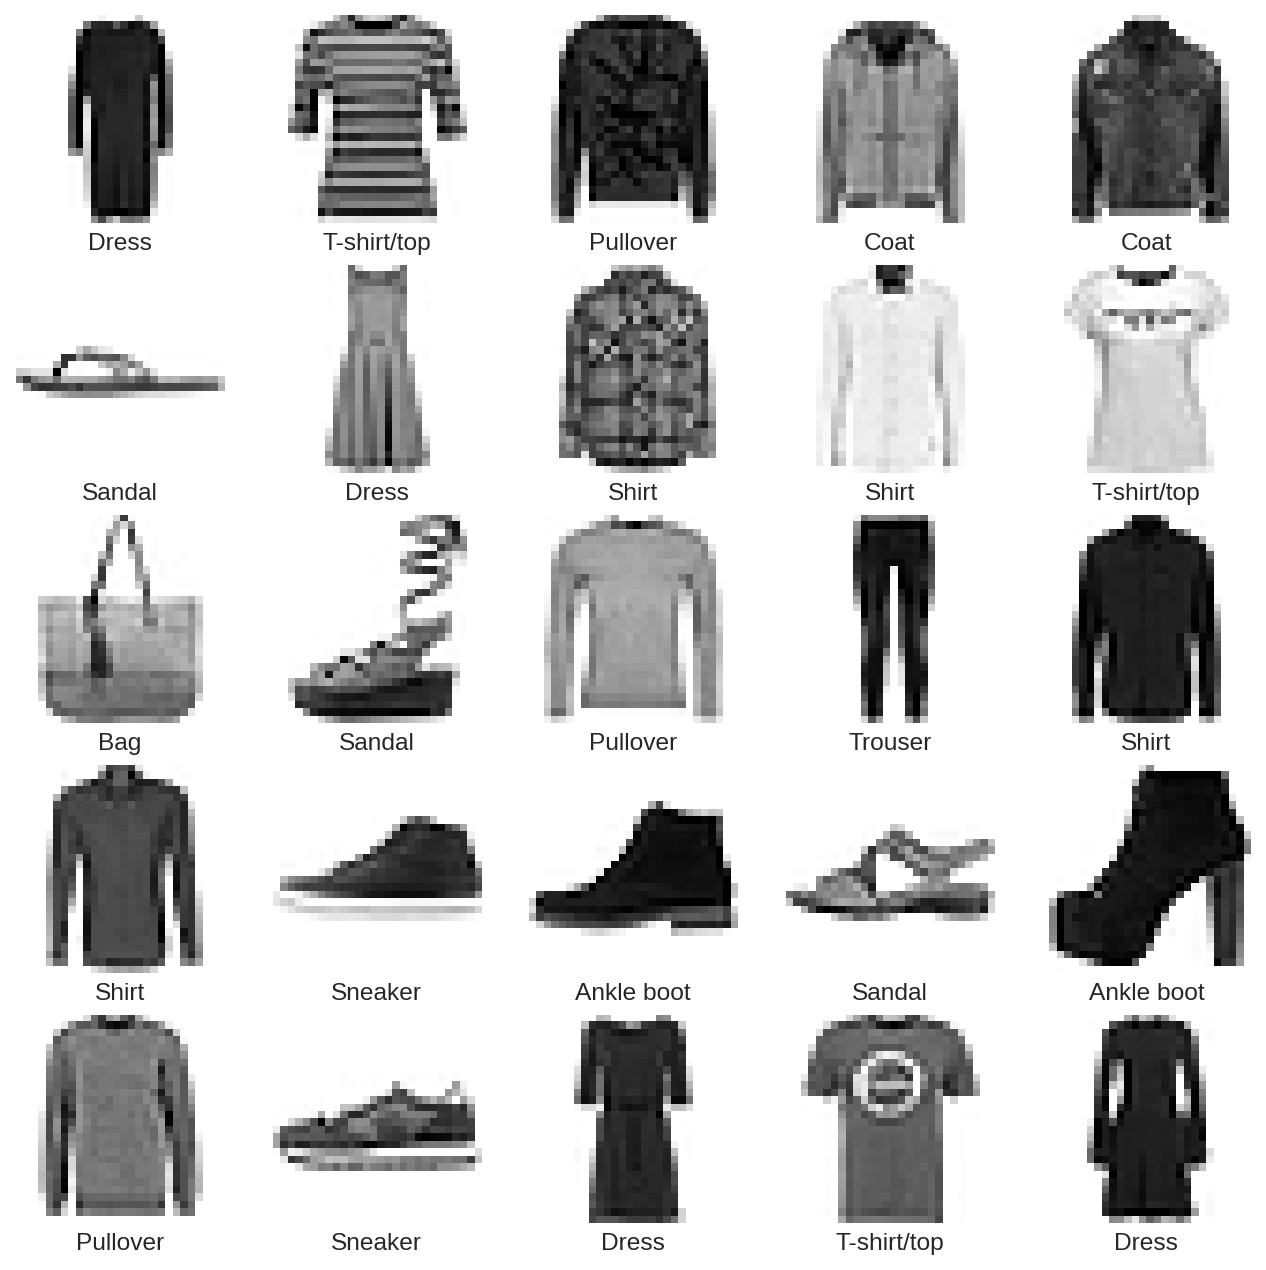

In [7]:
# Show class examples

fig = plt.figure(figsize=(10,10), dpi=160, facecolor='w')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])

In [8]:
## YOUR CODE HERE (Summarize the data)
## print basic info
print(f'X_train: {X_train.shape}')
class_info = list(sorted(Counter(y_train).items()))
print(f'num classes: {len(class_info)}, classes {[i[0] for i in class_info]}')
print(f'class samples: {[i[1] for i in class_info]}')
print(f'class balance: {[round(i[1]/X_train.shape[0],2) for i in class_info]}')
print(f'class names: {class_names}')


X_train: (60000, 28, 28)
num classes: 10, classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class samples: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
class balance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [23]:
## YOUR CODE HERE (base model)

X_train_flat = np.array([i.flatten() for i in train_images])
X_test_flat = np.array([i.flatten() for i in test_images])

def run_pipeline():
    
    pipe = Pipeline([('pca', PCA()),
                     ('svm', SVC(class_weight='balanced'))])

    param_grid = {
        'pca__n_components': [5, 10, 25],
        'svm__C': [0.001, 0.1, 10.0],
        'svm__gamma': [0.1, 0.01]
    }

    ## grid search
    time_start = time.time()
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=1, verbose=10)
    grid.fit(X_train_flat, y_train)
    y_pred = grid.predict(X_test_flat)

    print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))

    print(classification_report(y_test, y_pred, target_names=class_names))
    print(grid.best_params_)    
    

run_pipeline()

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.1, score=0.667, total= 3.2min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.1 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.1, score=0.660, total= 3.2min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.1 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.1, score=0.668, total= 3.2min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.1 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.7min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.1, score=0.671, total= 3.2min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.1 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.9min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.1, score=0.669, total= 3.2min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.01 ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.1min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.01, score=0.605, total= 2.8min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.01 ..............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 18.9min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.01, score=0.605, total= 2.8min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.01 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 21.7min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.01, score=0.611, total= 2.8min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.01 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 24.5min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.01, score=0.608, total= 2.8min
[CV] pca__n_components=5, svm__C=0.001, svm__gamma=0.01 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 27.3min remaining:    0.0s


[CV]  pca__n_components=5, svm__C=0.001, svm__gamma=0.01, score=0.612, total= 2.8min
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.1 .................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.1, score=0.751, total=  43.6s
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.1 .................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.1, score=0.746, total=  43.4s
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.1 .................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.1, score=0.749, total=  43.6s
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.1 .................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.1, score=0.748, total=  43.8s
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.1 .................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.1, score=0.745, total=  43.8s
[CV] pca__n_components=5, svm__C=0.1, svm__gamma=0.01 ................
[CV]  pca__n_components=5, svm__C=0.1, svm__gamma=0.01, score=0.725, total=  48

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 176.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train time  02:58:31
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.77      0.79      0.78      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.79      0.79      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.68      0.66      0.67      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

{'pca__n_components': 25, 'svm__C': 10.0, 'svm__gamma': 0.1}
